In [2]:
import numpy as np 
import awkward as ak
import sys
sys.path.append("..")
from binary_decoders import lecroy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft

0.10000004117581432


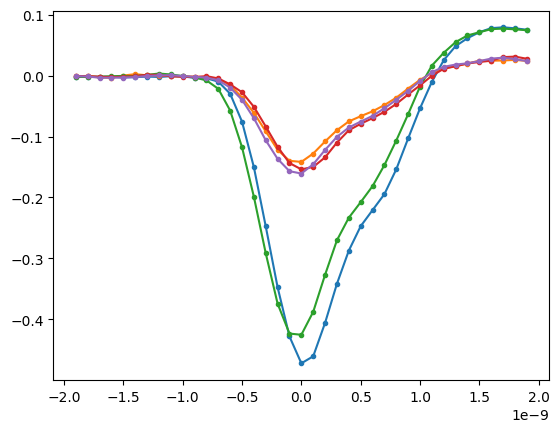

In [ ]:
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")

#plt.scatter(mcp_data.x[5], mcp_data.y[5], s=1)

# https://psec.uchicago.edu/blogs/lappd/wp-content/uploads/2008/08/Analytic_function.pdf
A = 1 + 10**(-4)
t0 = 1 * 10**(-9)
tau = 330*10**(-12)
AMP = 1.2*10**6

def h(t):
    return np.where(t > 0, (t / tau) * np.exp(-t / tau), 0)

def f(t):
    return np.where((t > 0) & (t < t0), A*((A/(A - 1))**(-t/t0)) - A, 0)

def g(t):
    dt = t[1] - t[0] # assuming constant sampling rate
    return ifft( fft(f(t)) * fft(h(t)) * dt)  * len(t)

ts = np.arange(-1,15,0.01)*10**(-9)
#plt.plot(ts + 2.48*10**-7, AMP*g(ts).real)


for i in range(5,10):
    # Extract the x and y data
    t_data = mcp_data.x[i]
    y_data = mcp_data.y[i]
    #plt.scatter(t_data[mask], y_data[mask], s=4)
    peak_time = t_data[np.argmin(y_data)]
    t_data = t_data - peak_time
    mask = (t_data > -0.002*10**(-6)) & (t_data < 0.002*10**(-6))
    plt.plot(t_data[mask], y_data[mask], marker='.')

print((t_data[1] - t_data[0])*10**9) # 0.1ns 

# find max and shift by that much time for the fit


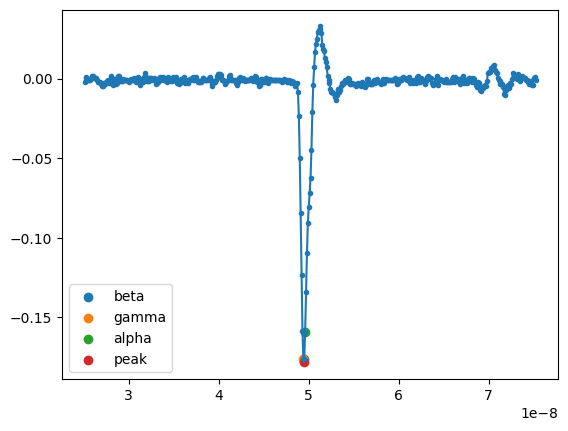

In [ ]:
def argnsmall(arr, n: int) -> float:
    return np.argpartition(arr, n)[n]

# interpolation fit method (columnar)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x[1]
y = mcp_data.y[1]

smallest_idxs = np.argpartition(y, 3)[:3]

peak_xs = x[smallest_idxs]
peak_ys = y[smallest_idxs]

def calc_parabola(x1,y1,x2,y2,x3,y3):
    matrix = np.array([
        [x1**2, x1, 1],
        [x2**2, x2, 1],
        [x3**2, x3, 1]
    ])
    inv_matrix = np.linalg.inv(matrix)
    y = np.array([y1, y2, y3])
    return inv_matrix @ y

A, B, C = calc_parabola(peak_xs[0], peak_ys[0], 
                        peak_xs[1], peak_ys[1], 
                        peak_xs[2], peak_ys[2])

peak = C - B**2 / (4*A)

plt.scatter(peak_xs[0], peak_ys[0], label="beta")
plt.scatter(peak_xs[1], peak_ys[1], label="gamma")
plt.scatter(peak_xs[2], peak_ys[2], label="alpha")
plt.scatter(-B/(2*A), peak, label="peak")

#mask = (x<0e-8) & (x>-0.15e-8)
#plt.plot(x[mask],y[mask], marker='.')
# plt.plot(x,y, marker='.')

plt.legend()

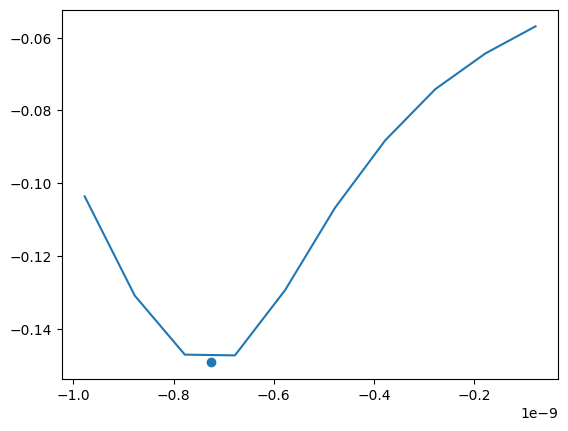

In [ ]:
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x
y = mcp_data.y

def interpolate_mcp_peak(seconds: np.ndarray, volts: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    For an array of MCP signal waveforms; where each waveform is the time and voltage of the siganl. 
    This grabs the 3 smallest values (so the peak) then does a parabolic interpolation of the actual peak

    Works only if you have enough points close to the signal peak. This function does the following,

    Lets say you have 3 points (x1,y1), (x2,y2), (x3,y3) you can create 3 equations,
    A*x1^2+B*x1+C=y1
    A*x2^2+B*x2+C=y2
    A*x3^2+B*x3+C=y3

    And then this is a matrix eq of form M*c = b,
    [x1^2 x1 1] [A]   [y1]
    |x2^2 x2 1| |B| = |y2|
    [x3^2 x3 1] [C]   [y3]

    To solve for A, B, C you can solve by doing c = M^-1 * b

    This function does this columnary for n waveforms where each waveform needs to have an interpolated peak.
    """
    # 1. Put indexes corresponding to 3 smallest values from each waveform (usually 5000 waveforms for 5000 events) first in the array
    data_peak_idxs = np.argpartition(volts, 3, axis=1)

    # 2. Grab x and y values along these indexes -> np.take_along_axis AND only want the first 3 elements from each waveform -> [:,:3]
    peak_xs = np.take_along_axis(seconds, data_peak_idxs, axis=1)[:,:3]
    peak_ys = np.take_along_axis(volts, data_peak_idxs, axis=1)[:,:3]

    # 3. Quadratic Interpolation of the peak using first 3 points
    # this creates an array of 3x3 equation matrices
    equation_matrix = np.stack(
        np.array([peak_xs**2, peak_xs, np.ones_like(peak_xs)]),
        axis=-1
    )
    inv_matrix = np.linalg.inv(equation_matrix)
    quadratic_coeff = np.einsum('ijk,ik->ij', inv_matrix, peak_ys) #thx gpt, does the matrix multiplication

    # for Ax^2 + Bx + C
    A, B, C = quadratic_coeff[:, 0], quadratic_coeff[:, 1], quadratic_coeff[:, 2]
    return -B/(2*A), C - B**2 / (4*A) #-> x_interpolated_peak, y_interpolated_peak

x = x[0]
y = y[0]
mask = (x<0e-8) & (x>-0.1e-8)
plt.plot(x[mask], y[mask])
plt.scatter(x_max[0], y_max[0], label="peak")
